# Analysis of Belle2 MonteCarlo Data

__Authors:__

- Valeria Fioroni (University of Padova)
- Matteo Guida (University of Padova)
- Philipp Zehetner (University of Padova, Ludwig Maximilian University of Munich)
- [Stack Overflow](https://stackoverflow.com/)


In [1]:
import os, sys, pprint
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
Testing = True # Uses only a small subset of the data and trains on fewer epochs. 
Local_Philipp = False
Local_Valeria = True
VM = False

if Testing: print("For testing purpose only a small number of events are used")
if Local_Philipp : print("Paths are set to be run on Philipps Computer")
elif VM : print("Paths are set to run on the VM")

For testing purpose only a small number of events are used


## Reading and Preparing Data

In [3]:
# Define branches that we need for our analysis
Masses = ['B0_M', 'B0_ErrM', 'B0_SigM', 'B0_K_S0_M', 'B0_K_S0_ErrM', 'B0_K_S0_SigM', 'B0_etap_M', 'B0_etap_ErrM', 
          'B0_etap_SigM', 'B0_etap_eta_M', 'B0_etap_eta_ErrM', 'B0_etap_eta_SigM']
Kinetics_CMS = ['B0_Pcms', 'B0_etap_Pcms', 'B0_etap_eta_Pcms', 'B0_etap_eta_gamma0_Pcms', 'B0_etap_eta_gamma1_Pcms',
                'B0_etap_pi0_Pcms', 'B0_etap_pi1_Pcms', 'B0_K_S0_Pcms']
Other_Kinetics = ['B0_deltae', 'B0_mbc']
DecayAngles = ['B0_decayAngle__bo0__bc', 'B0_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo0__bc',
               'B0_etap_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo2__bc']
Positions = ['B0_X', 'B0_ErrX', 'B0_Y', 'B0_ErrY', 'B0_Z', 'B0_ErrZ', 'B0_Rho',  
             'B0_etap_X', 'B0_etap_ErrX', 'B0_etap_Y', 'B0_etap_ErrY', 
             'B0_etap_Z', 'B0_etap_ErrZ', 'B0_etap_Rho',
             'B0_etap_eta_X', 'B0_etap_eta_ErrX', 'B0_etap_eta_Y',
             'B0_etap_eta_ErrY', 'B0_etap_eta_Z', 'B0_etap_eta_ErrZ', 'B0_etap_eta_Rho',
             'B0_etap_pi0_X', 'B0_etap_pi0_ErrX', 'B0_etap_pi0_Y', 'B0_etap_pi0_ErrY', 
             'B0_etap_pi0_Z', 'B0_etap_pi0_ErrZ', 'B0_etap_pi0_Rho', 
             'B0_etap_pi1_X', 'B0_etap_pi1_ErrX', 'B0_etap_pi1_Y', 'B0_etap_pi1_ErrY', 
             'B0_etap_pi1_Z', 'B0_etap_pi1_ErrZ', 'B0_etap_pi1_Rho', 
             'B0_K_S0_X', 'B0_K_S0_ErrX', 'B0_K_S0_Y', 'B0_K_S0_ErrY', 'B0_K_S0_Z',
             'B0_K_S0_ErrZ', 'B0_K_S0_Rho', 
             'B0_cosAngleBetweenMomentumAndVertexVector', 'B0_distance', 'B0_significanceOfDistance',
             'B0_dr', 'B0_etap_pi0_dr', 'B0_etap_pi1_dr', 'B0_K_S0_dr']
Vertex_Training = ['B0_VtxPvalue', 'B0_etap_VtxPvalue', 'B0_etap_eta_VtxPvalue', 'B0_etap_pi0_VtxPvalue',
                   'B0_etap_pi1_VtxPvalue', 'B0_K_S0_VtxPvalue', ]
Continuum_Suppression_Training = ['B0_TrCSMVA']

Training = Kinetics_CMS + Masses + Other_Kinetics + Continuum_Suppression_Training + Positions + DecayAngles + Vertex_Training
Important = Training + ['B0_isSignal', 'evt_no']

In [4]:
def memory(df):
    print(str((round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2))),"Mb")

In [5]:
from root_pandas import read_root

if Local_Philipp and not VM : 
    path = '/home/philipp/Desktop/Project/DATA/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Continuous/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Peaking/*.root'))
    
elif VM and not Local_Philipp : 
    print('Please set path for VM here')
    
elif Local_Valeria:  
    path = '/home/utente/Scrivania/Progetto LCP-B/DataBelle2/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Background/Continuum/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Background/Peaking/*.root'))
    

Signal = pd.concat((read_root(f, 'B0', columns=Important) for f in SFiles))
Signal = Signal[Signal['B0_isSignal']==1].reset_index(drop=True)
Continuum_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in CFiles))
Peaking_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in PFiles))

memory(Signal)
memory(Continuum_bkg)
memory(Peaking_bkg)

Welcome to JupyROOT 6.16/00
6.64 Mb
0.61 Mb
0.07 Mb


## Preselection

In [6]:
#Masses from PDG
M_B0 = [5.27955, 0.00026]
M_K0 = [0.497611, 0.000013]
M_etap = [0.95778, 0.00006]
M_eta = [0.547862, 0.000017]

#Require the B0 mass to be within 5 sigma from PDG value
Signal = Signal[abs(Signal['B0_M'] - M_B0[0]) < 5 * Signal['B0_ErrM']]
print(Signal.shape)

Continuum_bkg = Continuum_bkg[abs(Continuum_bkg['B0_M'] - M_B0[0]) < 5 * Continuum_bkg['B0_ErrM']]
print(Continuum_bkg.shape)

Peaking_bkg = Peaking_bkg[abs(Peaking_bkg['B0_M'] - M_B0[0]) < 5 * Peaking_bkg['B0_ErrM']]
print(Peaking_bkg.shape)

#Signal: In case of more than 1 candidate per event select the first one occuring
Mask_duplicated = Signal.duplicated(subset='evt_no', keep='first')
Mask_duplicated=np.logical_not(Mask_duplicated)
Signal=Signal[Mask_duplicated]
Signal.reset_index(drop=True, inplace=True)

print(Signal.shape)
print(Signal['evt_no'].nunique())

Signal=Signal[Training]
Continuum_bkg=Continuum_bkg[Training]
Peaking_bkg=Peaking_bkg[Training]


(19938, 85)
(908, 85)
(119, 85)
(19825, 85)
19825


## Preprocessing

In [7]:
from random import seed
from random import randint

n_seed=1234
seed(n_seed)

In [8]:
Signal['Type'] = 2
Continuum_bkg['Type'] = 1
Peaking_bkg['Type'] = 0

In [9]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

#SIGNAL: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Signal.drop('Type',axis=1)
Y = Signal['Type']
Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_S, X_test_val_S, Y_train_S, Y_test_val_S = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_S
Y = Y_test_val_S
X_validation_S, X_test_S, Y_validation_S, Y_test_S = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_S)
del(Y_test_val_S)

#CONTINUUM BKG: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Continuum_bkg.drop('Type',axis=1)
Y = Continuum_bkg['Type']
Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_C, X_test_val_C, Y_train_C, Y_test_val_C = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_C
Y = Y_test_val_C
X_validation_C, X_test_C, Y_validation_C, Y_test_C = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_C)
del(Y_test_val_C)

#PEAKING BKG: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Peaking_bkg.drop('Type',axis=1)
Y = Peaking_bkg['Type']
Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_P, X_test_val_P, Y_train_P, Y_test_val_P = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_P
Y = Y_test_val_P
X_validation_P, X_test_P, Y_validation_P, Y_test_P = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_P)
del(Y_test_val_P)

del(Signal)
del(Peaking_bkg)
del(Continuum_bkg)


Using TensorFlow backend.


In [13]:
#Define Training, Validation and Test datasets
X_Train=np.concatenate((X_train_S, X_train_C, X_train_P), axis=0)
X_Validation=np.concatenate((X_validation_S, X_validation_C, X_validation_P), axis=0)
X_Test=np.concatenate((X_test_S, X_test_C, X_test_P), axis=0)

Y_Train=np.concatenate((Y_train_S, Y_train_C, Y_train_P), axis=0)
Y_Validation=np.concatenate((Y_validation_S, Y_validation_C, Y_validation_P), axis=0)
Y_Test=np.concatenate((Y_test_S, Y_test_C, Y_test_P), axis=0)

print(X_Train.shape)
print(X_Validation.shape)
print(X_Test.shape)

print(X_Train.nbytes/(1024 ** 2), "Mb")
print(X_Validation.nbytes/(1024 ** 2), "Mb")
print(X_Test.nbytes/(1024 ** 2), "Mb")
n_classes = Y_Train.shape[1]


#shuffle the dataset
permutation = np.random.permutation(X_Train.shape[0])
X_Train = X_Train[permutation]
Y_Train = Y_Train[permutation]

permutation = np.random.permutation(X_Validation.shape[0])
X_Validation = X_Validation[permutation]
Y_Validation = Y_Validation[permutation]

permutation = np.random.permutation(X_Test.shape[0])
X_Test = X_Test[permutation]
Y_Test = Y_Test[permutation]

(10425, 83)
(6255, 83)
(4172, 83)
3.300762176513672 Mb
1.9804573059082031 Mb
1.3209381103515625 Mb


In [14]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_Train = ss.fit_transform(X_Train)
X_Test = ss.transform(X_Test)
X_Validation = ss.transform(X_Validation)



11 variables explain 50% of the variance
35 variables explain 90% of the variance
41 variables explain 95% of the variance
50 variables explain 99% of the variance


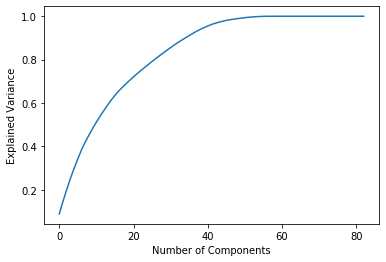

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

pca = PCA(n_components=len(Training))
pcTrain = pd.DataFrame(data = pca.fit_transform(X_Train))
pcTest = pd.DataFrame(data = pca.transform(X_Test))
pcValidation = pd.DataFrame(data = pca.transform(X_Validation))

T50, T90, T95, T99, = False, False, False, False
for i in range(len(pca.explained_variance_ratio_)) : 
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.5 and T50 ==False) : 
        print(str(i+1) + ' variables explain 50% of the variance')
        T50 = True
        n_50 = i + 1 
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.9 and T90 ==False) : 
        print(str(i+1) + ' variables explain 90% of the variance')
        T90 = True
        n_90 = i + 1
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.95 and T95 ==False) : 
        print(str(i+1) + ' variables explain 95% of the variance')
        T95 = True
        n_95 = i + 1
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.99 and T99 ==False) : 
        print(str(i+1) + ' variables explain 99% of the variance')
        T99 = True
        n_99 = i + 1
        
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

In [16]:
# For input_dim chose n_50, n_90, n_95 or n_99 depending on how much explained variance we require
input_dim = n_99
pcTrain = pcTrain.iloc[:, 0:input_dim]
pcTest = pcTest.iloc[:, 0:input_dim]
pcValidation = pcValidation.iloc[:, 0:input_dim]

## Create the Neural Network 

In [17]:
optimizer = ['SGD', 'Adam']
epochs = [10, 30]
if Testing : epochs = [1, 2]
batch_size = [100, 1000]
architectures = [ [50, 50], [50, 100, 50], [50, 100, 100, 50] ] 
activation = ['relu', 'elu']

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasClassifier

def build_DNN(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(pcTrain.shape[1],)))
    model.add(Dense(layers[0], input_shape=(pcTrain.shape[1],), activation='relu'))
    for i in range(1,len(layers)):
        model.add(Dense(layers[i], activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

def print_results() :
    print("Layers: ", layers)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params): 
        print("%f (%f) with %r" % (mean, stdev, param))


In [19]:
from sklearn.model_selection import GridSearchCV

results = []
grids = []
for architecture in architectures : 
    layers = architecture
    print("Using architecture: ", layers)
    model = KerasClassifier(build_fn=build_DNN, batch_size=10000, epochs=2)
    param_grid = dict(epochs=epochs, batch_size=batch_size,
                      activation=activation, optimizer=optimizer)
    grid = GridSearchCV(estimator=model, param_grid=param_grid,
                        n_jobs=-1, pre_dispatch=8)
    grid_result = grid.fit(pcTrain, Y_Train)
    results.append(grid_result)
    grids.append(grid)
    print_results()

Using architecture:  [50, 50]


/home/utente/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/2
10425/10425 [==============================] - 0s 36us/step - loss: 0.0523 - acc: 0.9345
Epoch 2/2
10425/10425 [==============================] - 0s 19us/step - loss: 0.0226 - acc: 0.9605
Layers:  [50, 50]
Best: 0.969305 using {'activation': 'relu', 'batch_size': 100, 'epochs': 2, 'optimizer': 'SGD'}
0.950791 (0.001175) with {'activation': 'relu', 'batch_size': 100, 'epochs': 1, 'optimizer': 'SGD'}
0.950791 (0.001175) with {'activation': 'relu', 'batch_size': 100, 'epochs': 1, 'optimizer': 'Adam'}
0.969305 (0.014178) with {'activation': 'relu', 'batch_size': 100, 'epochs': 2, 'optimizer': 'SGD'}
0.957026 (0.007611) with {'activation': 'relu', 'batch_size': 100, 'epochs': 2, 'optimizer': 'Adam'}
0.678369 (0.234092) with {'activation': 'relu', 'batch_size': 1000, 'epochs': 1, 'optimizer': 'SGD'}
0.902254 (0.034276) with {'activation': 'relu', 'batch_size': 1000, 'epochs': 1, 'optimizer': 'Adam'}
0.944652 (0.009299) with {'activation': 'relu', 'batch_size': 1000, 'epochs': 2, 'o

2019-07-17 19:35:04.674724: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-07-17 19:35:04.702326: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-07-17 19:35:04.785436: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-07-17 19:35:04.786964: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-07-17 19:35:28.447023: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


In [21]:
scores = []
params = []
for result in results : 
    scores.append(result.best_score_)
    params.append(result.best_params_)
    pprint.pprint(result.best_score_)
    pprint.pprint(result.best_params_)

0.9693045640449158
{'activation': 'relu', 'batch_size': 100, 'epochs': 2, 'optimizer': 'SGD'}
0.9586570814644976
{'activation': 'relu', 'batch_size': 100, 'epochs': 2, 'optimizer': 'Adam'}
0.9507913725267497
{'activation': 'relu', 'batch_size': 100, 'epochs': 1, 'optimizer': 'SGD'}


In [22]:
df = pd.DataFrame(results[2].cv_results_)
df#['mean_test_score','mean_training_score']

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_batch_size,param_epochs,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,3.440624,0.040821,0.784302,0.011451,relu,100,1,SGD,"{'activation': 'relu', 'batch_size': 100, 'epo...",0.949353,0.950791,0.95223,0.950791,0.001175,1
1,3.428734,0.088725,0.811687,0.092763,relu,100,1,Adam,"{'activation': 'relu', 'batch_size': 100, 'epo...",0.949353,0.950791,0.95223,0.950791,0.001175,1
2,3.880504,0.075978,0.809752,0.015348,relu,100,2,SGD,"{'activation': 'relu', 'batch_size': 100, 'epo...",0.949353,0.950791,0.95223,0.950791,0.001175,1
3,3.993593,0.066839,0.869181,0.012441,relu,100,2,Adam,"{'activation': 'relu', 'batch_size': 100, 'epo...",0.949353,0.950791,0.95223,0.950791,0.001175,1
4,3.414657,0.042670,0.796099,0.028633,relu,1000,1,SGD,"{'activation': 'relu', 'batch_size': 1000, 'ep...",0.949353,0.950791,0.95223,0.950791,0.001175,9
5,3.449368,0.072981,0.807863,0.034097,relu,1000,1,Adam,"{'activation': 'relu', 'batch_size': 1000, 'ep...",0.949353,0.950791,0.95223,0.950791,0.001175,9
6,3.812378,0.062351,0.856525,0.023761,relu,1000,2,SGD,"{'activation': 'relu', 'batch_size': 1000, 'ep...",0.949353,0.950791,0.95223,0.950791,0.001175,9
7,3.699022,0.022893,0.909008,0.051214,relu,1000,2,Adam,"{'activation': 'relu', 'batch_size': 1000, 'ep...",0.949353,0.950791,0.95223,0.950791,0.001175,9
8,3.879487,0.095858,1.213256,0.037353,elu,100,1,SGD,"{'activation': 'elu', 'batch_size': 100, 'epoc...",0.949353,0.950791,0.95223,0.950791,0.001175,1
9,4.427843,0.324523,1.259893,0.109092,elu,100,1,Adam,"{'activation': 'elu', 'batch_size': 100, 'epoc...",0.949353,0.950791,0.95223,0.950791,0.001175,1


### Evaluate the best Network

In [23]:
Best_Score = max(scores) # Best Score: 
Best_Params = params[scores.index(Best_Score)]
Best_Arch = architectures[scores.index(Best_Score)]
layers = Best_Arch
Best_Model = build_DNN(optimizer = Best_Params['optimizer'],
                       activation = Best_Params['activation'])
Best_Model.fit(pcTrain, Y_Train, batch_size = Best_Params['batch_size'],
               epochs = Best_Params['epochs'])

Epoch 1/2
10425/10425 [==============================] - 1s 58us/step - loss: 0.0567 - acc: 0.9282
Epoch 2/2
10425/10425 [==============================] - 0s 19us/step - loss: 0.0180 - acc: 0.9724


In [24]:
Best_Model.evaluate(pcTrain, Y_Train)

10425/10425 [==============================] - 0s 31us/step


[0.01080949076346392, 0.9828297362110312]

In [26]:
train_prediction = Best_Model.predict(pcTrain)
indeces = np.argmax(train_prediction, axis=1)
train_pred = to_categorical(indeces, num_classes=3)

In [27]:
train_pred

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [28]:
train_prediction

array([[0.02619588, 0.00724185, 0.9762729 ],
       [0.00896794, 0.00422175, 0.99003613],
       [0.00748911, 0.00616784, 0.9887843 ],
       ...,
       [0.00787643, 0.01463574, 0.97333515],
       [0.01044527, 0.02211081, 0.98362654],
       [0.01078404, 0.0061514 , 0.99534154]], dtype=float32)

In [29]:
N_true = 0
N_false = 0
for i in range(len(train_pred)) : 
    if train_pred[i].all() == Y_Train[i].all() : N_true += 1
    else : N_false += 1
        
print ("Accuracy = ", N_true/(N_true+N_false))
print ("N_true: ", N_true)
print ("N_false: ", N_false)

Accuracy =  1.0
N_true:  10425
N_false:  0


In [30]:
print(Best_Model.evaluate(pcTrain, Y_Train))
print(Best_Model.evaluate(pcValidation, Y_Validation))

10425/10425 [==============================] - 0s 23us/step
[0.01080949076346392, 0.9828297362110312]
6255/6255 [==============================] - 0s 24us/step
[0.011626645446874851, 0.9816147082334132]


In [31]:
train_prediction = Best_Model.predict(pcValidation)
indeces = np.argmax(train_prediction, axis=1)
train_pred = to_categorical(indeces, num_classes=3)

N_true = 0
N_false = 0
for i in range(len(train_pred)) : 
    if np.array_equal(Y_Validation[i], train_pred[i]) : N_true += 1
    else : N_false += 1
        
print ("Accuracy = ", N_true/(N_true+N_false))
print ("N_true: ", N_true)
print ("N_false: ", N_false)

Accuracy =  0.9816147082334132
N_true:  6140
N_false:  115


In [32]:
print("Trainig Error : ",1-Best_Model.evaluate(pcTrain, Y_Train)[1])
print("Validation Error : ",1-Best_Model.evaluate(pcValidation, Y_Validation)[1])

10425/10425 [==============================] - 0s 24us/step
Trainig Error :  0.017170263788968798
6255/6255 [==============================] - 0s 29us/step
Validation Error :  0.018385291766586764


In [33]:
y_score = Best_Model.predict(pcValidation)
for s in y_score : 
    print(s)

[0.01694945 0.01680683 0.96709853]
[3.4052313e-03 8.4564456e-04 9.9311936e-01]
[0.03725956 0.0146431  0.97588784]
[0.01447821 0.00822299 0.9736718 ]
[0.00978837 0.00667875 0.98476565]
[0.00436265 0.00823297 0.98950654]
[0.00193405 0.00545828 0.99707484]
[0.0549725  0.04206709 0.9535578 ]
[0.01763047 0.01319368 0.9665375 ]
[0.00464916 0.00251593 0.9963815 ]
[0.00745171 0.00763913 0.9919716 ]
[0.00529696 0.00937248 0.98413426]
[0.00283263 0.00439304 0.9818817 ]
[0.02265572 0.01774672 0.95646846]
[0.00396644 0.9839972  0.0218062 ]
[0.0032047  0.00684505 0.9895717 ]
[0.00219712 0.00524825 0.99375916]
[0.00546819 0.00388415 0.99475855]
[0.00443887 0.00566754 0.9946443 ]
[0.01526541 0.05120169 0.96784884]
[0.04414557 0.07525886 0.8829501 ]
[0.02651062 0.07580198 0.9614586 ]
[0.01035934 0.00616862 0.99027467]
[0.0151327  0.01850043 0.96178   ]
[0.00834968 0.00611429 0.9896375 ]
[0.00641363 0.02177594 0.98020923]
[0.00472667 0.00888471 0.9837437 ]
[0.00415256 0.01650383 0.9810372 ]
[0.04395959

[0.01798023 0.03104093 0.9765602 ]
[0.00347008 0.00195612 0.99548787]
[0.04251706 0.02560727 0.9595144 ]
[0.03787688 0.06513168 0.88431925]
[0.01050723 0.0081655  0.9703996 ]
[0.00606616 0.00513666 0.9888024 ]
[0.0384415  0.03162444 0.9662533 ]
[0.00556458 0.03539122 0.98827887]
[0.00725638 0.01222336 0.98540026]
[0.00825344 0.00987165 0.9817302 ]
[3.0786493e-03 7.7564269e-04 9.9764866e-01]
[0.02170539 0.7351583  0.1626467 ]
[0.00157598 0.01692135 0.95662105]
[0.01027684 0.00390109 0.98008853]
[0.00884256 0.01854721 0.9832923 ]
[0.00215969 0.06632788 0.9169042 ]
[0.04585202 0.23925607 0.8020179 ]
[0.0139569  0.01322729 0.985255  ]
[0.00133053 0.00531224 0.99568695]
[0.01621901 0.02266376 0.9755643 ]
[0.02230672 0.0142023  0.9754524 ]
[0.02321553 0.00973705 0.9884852 ]
[0.02578434 0.0069388  0.9817425 ]
[0.02310083 0.00769058 0.98557633]
[0.01639287 0.0575811  0.9448857 ]
[0.04002533 0.04770961 0.9561829 ]
[2.9069879e-08 1.4597741e-07 9.9999940e-01]
[0.00648461 0.00132054 0.9922471 ]
[0

[0.02405232 0.05611613 0.9803376 ]
[0.04212797 0.03077785 0.93521434]
[0.02064215 0.19556682 0.710969  ]
[0.01307571 0.01774514 0.974963  ]
[0.01958048 0.10734848 0.94576466]
[0.0109841  0.00752536 0.98650753]
[0.03730728 0.01036173 0.9651186 ]
[0.03517718 0.03416249 0.9825462 ]
[0.01500076 0.0421362  0.93536264]
[0.01413227 0.06220182 0.9746021 ]
[0.01537318 0.02068982 0.9758158 ]
[0.01513724 0.03280155 0.94375217]
[0.01664607 0.01073226 0.99153066]
[0.01053578 0.00851232 0.9801971 ]
[0.0046073  0.01954956 0.9870799 ]
[0.00410707 0.00358781 0.99174494]
[0.00422998 0.00212704 0.99894875]
[0.017412   0.01379128 0.9937889 ]
[0.0126727  0.01799977 0.98039   ]
[0.00898238 0.02150435 0.9833422 ]
[0.01956308 0.17285171 0.7267653 ]
[0.07775826 0.02763989 0.941128  ]
[5.3147909e-05 1.1580168e-04 9.9993551e-01]
[0.02211324 0.04855749 0.80660874]
[0.00396713 0.01596291 0.965362  ]
[0.02112959 0.01146017 0.9800519 ]
[0.01507805 0.00331096 0.9711574 ]
[0.00365181 0.00977138 0.9546699 ]
[0.02180151

[0.00735287 0.04253544 0.9464992 ]
[0.00926274 0.01154786 0.958154  ]
[0.02529574 0.07585558 0.88834906]
[0.02252296 0.01506655 0.96753293]
[0.01475896 0.01185104 0.98078144]
[0.01070814 0.04120895 0.9295351 ]
[0.0761601 0.0774424 0.8672455]
[0.00931575 0.03856944 0.9815741 ]
[0.00820474 0.00620642 0.98184144]
[0.02208366 0.02856504 0.9555498 ]
[0.01828535 0.01509841 0.9774786 ]
[0.00672418 0.00732534 0.99261427]
[0.00608344 0.0135096  0.9914745 ]
[0.01967321 0.02303062 0.9663204 ]
[0.03100098 0.02625413 0.9751541 ]
[0.03464115 0.03070833 0.9712157 ]
[0.0197797  0.00470564 0.9934894 ]
[0.00175606 0.0054613  0.99038726]
[0.01256585 0.02298605 0.9686092 ]
[0.03147369 0.00814937 0.9757382 ]
[0.00249296 0.9606987  0.02680114]
[0.02228566 0.02213704 0.9768273 ]
[0.01538995 0.01503374 0.9721737 ]
[0.02014054 0.02631017 0.9678917 ]
[0.01443309 0.00365612 0.9927631 ]
[0.0055813  0.01155061 0.975391  ]
[0.00750864 0.00918629 0.9843205 ]
[0.02419561 0.06381369 0.89425766]
[0.02784305 0.02204464 

[0.00889027 0.02217488 0.98080105]
[0.01702657 0.01752762 0.9366479 ]
[0.02403709 0.91972846 0.03529761]
[0.01632663 0.00568189 0.98884124]
[0.01662426 0.00607589 0.960726  ]
[0.00427818 0.01434767 0.9917671 ]
[0.05033003 0.12957543 0.80157745]
[0.02003933 0.00796581 0.975071  ]
[0.00719716 0.00551638 0.9915104 ]
[0.00904766 0.02272506 0.9784418 ]
[0.03105498 0.0065343  0.9789234 ]
[0.01989698 0.813985   0.16393304]
[0.00411481 0.00331391 0.9866947 ]
[0.01398718 0.03178073 0.94215804]
[0.0136489  0.05626269 0.95255035]
[0.0529027  0.04485456 0.89469284]
[0.01798118 0.01237953 0.9375078 ]
[0.02295237 0.08310621 0.9552262 ]
[0.01143157 0.67714757 0.23770049]
[0.02354604 0.00722034 0.9893265 ]
[0.01072791 0.01154623 0.98484784]
[0.01528429 0.01184212 0.98177415]
[0.0282858  0.01440596 0.9575728 ]
[0.0043164  0.00215386 0.9935968 ]
[0.02511557 0.12543163 0.86327857]
[0.07378106 0.07368797 0.92277706]
[2.3787376e-05 2.2872988e-04 9.9984193e-01]
[0.00826065 0.01594236 0.98462796]
[0.01078392

[0.0075949  0.0222309  0.95224565]
[0.04219543 0.0690923  0.9674329 ]
[0.01335883 0.00409847 0.9787203 ]
[0.00927931 0.01224572 0.9762306 ]
[0.05344723 0.04710059 0.9504715 ]
[0.03927378 0.04180202 0.8971501 ]
[6.6239369e-04 3.6511160e-03 9.9803466e-01]
[0.02036649 0.03377312 0.8691806 ]
[0.01551238 0.08558627 0.9705358 ]
[0.00439334 0.00367122 0.98793715]
[0.01429738 0.01760265 0.98112446]
[0.01514575 0.30906102 0.8052271 ]
[6.8258552e-04 2.0066623e-03 9.9767631e-01]
[0.00870416 0.0033091  0.9827087 ]
[0.00879339 0.07265007 0.81011045]
[0.00762862 0.00459902 0.9711987 ]
[0.00818649 0.03728882 0.98789597]
[0.01205615 0.02592133 0.9670874 ]
[0.02517676 0.05082384 0.8864088 ]
[0.00925752 0.00952344 0.9904192 ]
[0.02149862 0.1098121  0.93284523]
[0.0110876  0.01463294 0.97394073]
[0.00872802 0.01825542 0.97948974]
[0.06964868 0.03129693 0.95228183]
[0.02868894 0.0157677  0.98618454]
[0.00763604 0.01264373 0.9780748 ]
[0.00545052 0.03529783 0.9837579 ]
[0.02058648 0.01250147 0.96758324]
[0

[0.00926211 0.08182567 0.91148305]
[2.0526727e-03 9.8477327e-04 9.9774545e-01]
[0.01504308 0.02728139 0.9582254 ]
[0.05184414 0.07336824 0.93924147]
[0.01720063 0.01529215 0.9813793 ]
[0.01923122 0.02528945 0.9809178 ]
[0.00486173 0.00255721 0.9933855 ]
[0.02319541 0.03640381 0.9326655 ]
[0.02224755 0.04997851 0.97021365]
[0.00458964 0.00289005 0.9933134 ]
[0.00169556 0.9896255  0.00440014]
[0.0129187  0.07968806 0.93431544]
[0.02849084 0.06601752 0.9478591 ]
[0.00416463 0.00285    0.9924953 ]
[0.00887205 0.00659308 0.9954691 ]
[0.02815258 0.068586   0.9692705 ]
[0.02521312 0.0287437  0.9594087 ]
[0.01248181 0.0102444  0.9740413 ]
[0.00368012 0.01110651 0.99308723]
[0.00441389 0.01399064 0.9734572 ]
[0.01042104 0.00415787 0.9904801 ]
[0.02952641 0.00875608 0.97646254]
[0.05088236 0.05465301 0.9547568 ]
[0.01734575 0.00908351 0.9825682 ]
[0.01712929 0.00834914 0.9790496 ]
[0.03013602 0.03899831 0.98404676]
[0.01343052 0.02197374 0.9796215 ]
[0.01526448 0.02841697 0.98376954]
[0.00415443

[0.02408619 0.01192275 0.98490626]
[0.02346765 0.05187414 0.95553714]
[6.4666232e-04 1.9661065e-03 9.9917608e-01]
[0.01020137 0.01580144 0.95829546]
[0.02715092 0.02315882 0.9784863 ]
[0.02614793 0.00446664 0.98343235]
[0.01404989 0.03175148 0.9415056 ]
[0.01418244 0.02441029 0.985195  ]
[0.02229077 0.01238291 0.9802357 ]
[0.01290686 0.01188216 0.97705334]
[0.01957303 0.0323163  0.9480001 ]
[0.08710776 0.0880138  0.9571758 ]
[0.02048605 0.04157879 0.9141191 ]
[0.00694668 0.00270912 0.98162097]
[0.03040725 0.01844021 0.94451076]
[0.01822305 0.9198447  0.16753685]
[0.00429904 0.01773572 0.9837646 ]
[0.01763363 0.0261125  0.9851109 ]
[0.0150298  0.07515938 0.98149925]
[0.01316612 0.00343159 0.9893973 ]
[0.00280139 0.00134572 0.9955022 ]
[0.0300019  0.01089126 0.98725337]
[0.00320008 0.00193614 0.9960401 ]
[0.01393605 0.01162802 0.97753793]
[1.9081372e-04 1.0313183e-03 9.9758565e-01]
[0.02126414 0.02753654 0.8677355 ]
[0.00978579 0.01662199 0.9676559 ]
[0.02844031 0.03658643 0.9090753 ]
[7

[0.01820259 0.02144253 0.93126106]
[0.00892815 0.02446651 0.97851735]
[0.05031548 0.03436961 0.9463706 ]
[0.01667195 0.01410912 0.9788608 ]
[0.04308591 0.01686304 0.9127931 ]
[0.01183868 0.00518005 0.9963967 ]
[0.03972157 0.07817028 0.8763991 ]
[0.01989124 0.00723512 0.9794692 ]
[0.02944842 0.14947094 0.95480853]
[0.02577786 0.02485743 0.94817966]
[0.04758514 0.06843574 0.8991683 ]
[0.00548796 0.00256464 0.99539787]
[1.402317e-05 1.779266e-03 9.985668e-01]
[0.02612626 0.03993773 0.98982036]
[0.02131963 0.04647831 0.9517734 ]
[0.0228796  0.05592429 0.94970375]
[0.03343502 0.02067833 0.96866995]
[0.014984   0.09411896 0.8926274 ]
[0.00971543 0.01742298 0.9899815 ]
[0.03114369 0.03134082 0.9672633 ]
[0.01174887 0.01225222 0.9942451 ]
[0.01160153 0.00367788 0.9872012 ]
[0.00878609 0.01321519 0.9791317 ]
[0.04722841 0.10638028 0.7972378 ]
[0.00731699 0.03794735 0.95000553]
[0.03409723 0.12838644 0.87787384]
[0.04442435 0.05739377 0.9684313 ]
[0.0415686  0.05786438 0.9204372 ]
[0.00402096 0.

[0.00359014 0.00619036 0.99301827]
[0.01001881 0.00999787 0.9757047 ]
[0.00275952 0.01404035 0.95616764]
[6.002795e-04 8.028629e-03 9.924900e-01]
[0.01176982 0.0034443  0.9950885 ]
[0.00663194 0.0135997  0.9900046 ]
[0.03889204 0.01728117 0.9392137 ]
[0.01602471 0.01513782 0.97948945]
[0.05102091 0.01451313 0.9815228 ]
[0.03012194 0.00605023 0.9893812 ]
[0.00847898 0.04789498 0.9798663 ]
[0.00527794 0.07454827 0.7724942 ]
[0.00408264 0.02728264 0.9720304 ]
[0.01814262 0.03838462 0.9395582 ]
[8.7145652e-04 1.2279243e-03 9.9974734e-01]
[0.02770374 0.01519799 0.98389834]
[0.00502839 0.00852199 0.9930646 ]
[0.03994424 0.02674339 0.9708082 ]
[0.03490124 0.06715154 0.88755536]
[0.01378272 0.00564858 0.95789224]
[0.00201381 0.00321297 0.99008614]
[0.01279701 0.01095162 0.96923065]
[0.03247575 0.07815596 0.9353941 ]
[0.01614988 0.02179729 0.9729748 ]
[0.00837352 0.01715699 0.95897907]
[0.02947197 0.07607533 0.94136965]
[0.00419664 0.00870381 0.9799661 ]
[0.01422493 0.00579525 0.9781174 ]
[0.00

[0.01280929 0.00796953 0.98227835]
[0.03169888 0.05160069 0.9159927 ]
[0.02237776 0.00806455 0.9863294 ]
[0.00886934 0.04920396 0.9691984 ]
[0.00289126 0.00185234 0.9914091 ]
[0.0061513  0.03548447 0.9881749 ]
[0.01667797 0.03890564 0.96895325]
[0.00543196 0.0033127  0.98407286]
[0.00787908 0.07430297 0.867845  ]
[0.0259755  0.02068576 0.9740215 ]
[0.00511283 0.01387178 0.9665368 ]
[0.03747728 0.04246387 0.9715584 ]
[0.01494372 0.02862043 0.9580317 ]
[0.01201839 0.12319771 0.80875474]
[5.0706574e-05 2.5523192e-04 9.9640238e-01]
[0.01050397 0.00382642 0.97117245]
[0.02143718 0.02577764 0.9446236 ]
[0.00761342 0.00840522 0.9924717 ]
[0.00473825 0.01449823 0.98240775]
[8.5358392e-04 2.6866919e-03 9.9937516e-01]
[0.02471763 0.01143751 0.97276795]
[0.04286068 0.03746862 0.9115799 ]
[0.00328653 0.00486312 0.9947706 ]
[0.01399632 0.01561356 0.9766967 ]
[0.02734309 0.01392043 0.984932  ]
[0.03829087 0.03546007 0.9553666 ]
[0.01109226 0.03863824 0.9706889 ]
[0.0069559  0.03243859 0.97813326]
[0

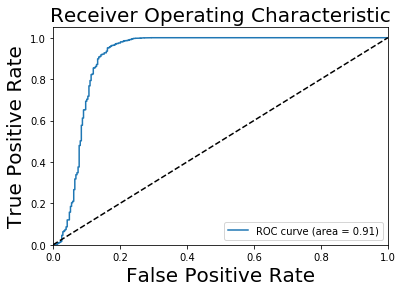

In [34]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_Validation[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('Receiver Operating Characteristic',fontsize=20)
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=15)

    plt.ylabel('TRUE LABEL',fontsize=20)
    plt.xlabel('PREDICTED LABEL',fontsize=20)
    #fig.set_size_inches(14, 10)
    plt.tight_layout()

In [36]:
from sklearn.metrics import confusion_matrix

#Y_train_predict = Best_Model.predict_proba(pcTrain)
Y_val_predict = Best_Model.predict_proba(pcValidation)
Y_val_single_col = np.where(Y_Validation==1)[1]
Y_val_mo = pd.get_dummies(Y_val_single_col[:])
Y_val_predict_mo = Y_val_predict.round()
cnf_matrix = confusion_matrix(Y_val_mo.values.argmax(axis=1), Y_val_predict_mo.argmax(axis=1))

Normalized confusion matrix
[[0.05555556 0.19444444 0.75      ]
 [0.03676471 0.70588235 0.25735294]
 [0.         0.         1.        ]]


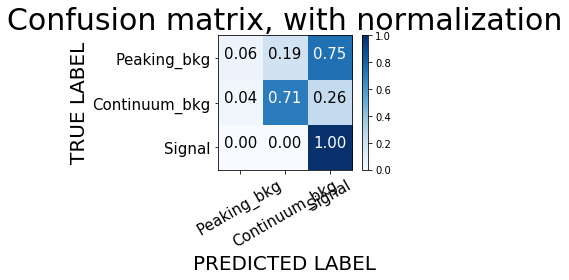

In [38]:
import itertools

plot_confusion_matrix(cnf_matrix, classes=['Peaking_bkg', 'Continuum_bkg', 'Signal'],
                       title='Confusion matrix, with normalization')

### Store the Weights

In [39]:
# !!! DO STUFF!!!

## XGBOOST

In [42]:
#%%time
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

print("Training on %i examples with %i features"%X_train.shape)

#Use default parameters and train on full dataset
XGBclassifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=1, n_estimators=1000,n_jobs = 1,objective = 'multi:softmax',silent=1,tree_method='approx')
#Train and time classifier
XGBclassifier.fit(X_train, Y_train_single_col)

#Make Predictions
print("Predicting on %i examples with %i features\n"%X_test.shape)
y_pred= XGBclassifier.predict(X_test)

#Print Results
print("Model Accuracy with all features: {:.2f}%".format(100*XGBclassifier.score(X_test, Y_test_single_col)))



Training on 10425 examples with 83 features
Predicting on 4172 examples with 83 features

Model Accuracy with all features: 95.04%
